In [1]:
import urllib.request
import os.path
import numpy
import netCDF4
import scipy.sparse
import scipy.sparse.linalg
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fetch_file_from_web(url, filename=None, force_download=False):
    """Download file from url and optionally names it as filename"""
    if filename is None: local_file = os.path.split(url)[-1]
    else: local_file = filename
    if not os.path.isfile(local_file) or force_download:
        print('Downloading file %s ...'%local_file)
        urllib.request.urlretrieve(url, local_file)
        print(' ...done.')

In [3]:
fetch_file_from_web('ftp://ftp.gfdl.noaa.gov/home/aja/OM4_05_grid.unpacked/ocean_hgrid.nc')
fetch_file_from_web('ftp://ftp.gfdl.noaa.gov/home/aja/OM4_05_grid.unpacked/ocean_mask.nc')

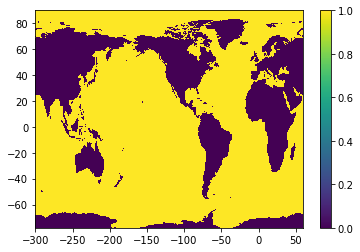

In [4]:
ocn_qlon = netCDF4.Dataset('ocean_hgrid.nc').variables['x'][::2,::2]
ocn_qlat = netCDF4.Dataset('ocean_hgrid.nc').variables['y'][::2,::2]
ocn_mask = netCDF4.Dataset('ocean_mask.nc').variables['mask'][:,:]
ocn_nj, ocn_ni = ocn_mask.shape
plt.pcolormesh(ocn_qlon, ocn_qlat, ocn_mask); plt.colorbar();

In [5]:
src_nc = netCDF4.Dataset('seawifs-clim-1997-2010.nc')
src_data = src_nc.variables['chlor_a']
src_nj, src_ni = src_data.shape[-2], src_data.shape[-1]
print('src shape = %i x %i'%(src_nj,src_ni))
src_lon = src_nc.variables[src_data.dimensions[-1]]
src_lat = src_nc.variables[src_data.dimensions[-2]]
src_lat = ((numpy.arange(src_nj)+0.5)/src_nj - 0.5)*180. # Recompute as doubles
src_x0 = int( ( src_lon[0] + src_lon[-1] )/2 + 0.5) - 180.
src_lon = ((numpy.arange(src_ni)+0.5)/src_ni)*360.+src_x0 # Recompute as doubles
src_qlat = ((numpy.arange(src_nj+1))/src_nj - 0.5)*180. # For plotting
src_qlon = ((numpy.arange(src_ni+1))/src_ni)*360.+src_x0 # For plotting

src shape = 2160 x 4320


In [6]:
def super_sample_grid(ocn_qlat, ocn_qlon, ocn_mask, src_nj, src_ni):
    nj, ni = ocn_mask.shape
    fac = 1
    while fac*nj<src_nj and fac*ni<src_ni:
        fac += 1
    lon = numpy.zeros( (nj,fac,ni,fac) )
    lat = numpy.zeros( (nj,fac,ni,fac) )
    mask = numpy.zeros( (nj,fac,ni,fac) )
    for j in range(fac):
        ya = ( 2*j+1 ) / ( 2*fac )
        yb = 1. - ya
        for i in range(fac):
            xa = ( 2*i+1 ) / ( 2*fac )
            xb = 1. - xa
            lon[:,j,:,i] = (  yb * ( xb * ocn_qlon[:-1,:-1] + xa * ocn_qlon[:-1,1:] )
                            + ya * ( xb * ocn_qlon[1:,:-1] + xa * ocn_qlon[1:,1:] ) )
            lat[:,j,:,i] = (  yb * ( xb * ocn_qlat[:-1,:-1] + xa * ocn_qlat[:-1,1:] )
                            + ya * ( xb * ocn_qlat[1:,:-1] + xa * ocn_qlat[1:,1:] ) )
    return lat, lon
spr_lat, spr_lon = super_sample_grid(ocn_qlat, ocn_qlon, ocn_mask, src_nj, src_ni)

In [7]:
def latlon2ji(src_lat, src_lon, lat, lon):
    nj, ni = len(src_lat), len(src_lon)
    src_x0 = int( ( src_lon[0] + src_lon[-1] )/2 + 0.5) - 180.
    j = numpy.maximum(0, numpy.floor( ( ( lat + 90. ) / 180. ) * nj - 0.5 ).astype(int))
    i = numpy.mod( numpy.floor( ( ( lon - src_x0 ) / 360. ) * ni - 0.5 ), ni ).astype(int)
    jp1 = numpy.minimum(nj-1, j+1)
    ip1 = numpy.mod(i+1, ni)
    return j,i,jp1,ip1
y, x = src_lat[0], src_lon[0]
latlon2ji(src_lat, src_lon, y, x)

(0, 4319, 1, 0)

278992

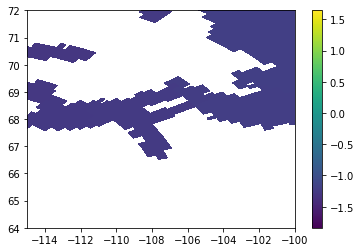

In [35]:
def super_interp(src_lat, src_lon, data, spr_lat, spr_lon):
    nj, ni = data.shape
    dy, dx = 180./nj, 360./ni
    j0, i0, j1, i1 = latlon2ji(src_lat, src_lon, spr_lat, spr_lon)
    def ydist(lat0, lat1):
        return numpy.abs( lat1-lat0 )
    def xdist(lon0, lon1):
        return numpy.abs( numpy.mod((lon1-lon0)+180, 360) - 180 )
    w_e = xdist( src_lon[i0], spr_lon) / dx
    w_w = 1. - w_e
    w_n = ydist( src_lat[j0], spr_lat) / dy
    w_s = 1. - w_n
    return ( w_s*w_w * data[j0,i0] + w_n*w_e * data[j1,i1] ) + ( w_n*w_w * data[j1,i0] + w_s*w_e * data[j0,i1] )
q_int = super_interp(src_lat, src_lon, src_data[0], spr_lat, spr_lon)
## q_int = q_int.mean(axis=-1).mean(axis=1) # reduce to ocean grid
q_int = q_int.swapaxes(1,2).reshape((ocn_nj,ocn_ni,q_int.shape[3]*q_int.shape[-1])).mean(axis=-1)
plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10( q_int ) ); plt.colorbar();
plt.xlim(-115,-100); plt.ylim(64,72);
(1-q_int.mask).sum()

(278992, 269496)

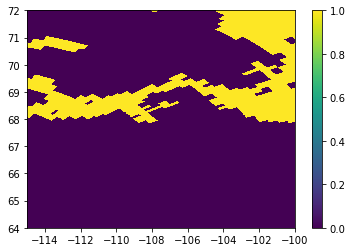

In [40]:
q = q_int * ocn_mask
#q = numpy.ma.array( q_int.filled(-1e9), mask=(q_int.mask | (ocn_mask==0)) )
#plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10( q ) ); plt.colorbar();
plt.pcolormesh(ocn_qlon, ocn_qlat, ocn_mask ); plt.colorbar();
plt.xlim(-115,-100); plt.ylim(64,72);
(1-q.mask).sum(), int(ocn_mask.sum()),

In [37]:
def fill_missing_data(idata, mask, verbose=False, maxiter=0, debug=False, stabilizer=1.e-14):
    """
    Returns data with masked values objectively interpolated except where mask==0.
    
    Arguments:
    data - numpy.ma.array with mask==True where there is missing data or land.
    mask - numpy.array of 0 or 1, 0 for land, 1 for ocean.
    
    Returns a numpy.ma.array.
    """
    nj,ni = idata.shape
    fdata = idata.filled(0.) # Working with an ndarray is faster than working with a masked array
    if debug:
        plt.figure(); plt.pcolormesh(mask); plt.title('mask'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata.mask); plt.title('idata.mask'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata); plt.title('idata'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata.filled(3.)); plt.title('idata.filled'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata.filled(3.)); plt.title('fdata'); plt.colorbar();
    missing_j, missing_i = numpy.where( idata.mask & (mask>0) )
    n_missing = missing_i.size
    if verbose:
        print('Data shape: %i x %i = %i with %i missing values'%(nj, ni, nj*ni, numpy.count_nonzero(idata.mask)))
        print('Mask shape: %i x %i = %i with %i land cells'%(mask.shape[0], mask.shape[1],
                                                                 numpy.prod(mask.shape), numpy.count_nonzero(1-mask)))
        print('Data has %i missing values in ocean'%(n_missing))
        print('Data range: %g .. %g '%(idata.min(),idata.max()))
    # ind contains column of matrix/row of vector corresponding to point [j,i]
    ind = numpy.zeros( fdata.shape, dtype=int ) - int(1e6)
    ind[missing_j,missing_i] = numpy.arange( n_missing )
    if verbose: print('Building matrix')
    A = scipy.sparse.lil_matrix( (n_missing, n_missing) )
    b = numpy.zeros( (n_missing) )
    ld = numpy.zeros( (n_missing) )
    A[range(n_missing),range(n_missing)] = 0.
    if verbose: print('Looping over cells')
    for n in range(n_missing):
        j,i = missing_j[n],missing_i[n]
        im1 = ( i + ni - 1 ) % ni
        ip1 = ( i + 1 ) % ni
        jm1 = max( j-1, 0)
        jp1 = min( j+1, nj-1)
        if j>0 and mask[jm1,i]>0:
            ld[n] -= 1.
            ij = ind[jm1,i]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[jm1,i]
        if mask[j,im1]>0:
            ld[n] -= 1.
            ij = ind[j,im1]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[j,im1]
        if mask[j,ip1]>0:
            ld[n] -= 1.
            ij = ind[j,ip1]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[j,ip1]
        if j<nj-1 and mask[jp1,i]>0:
            ld[n] -= 1.
            ij = ind[jp1,i]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[jp1,i]
        if j==nj-1 and mask[j,ni-1-i]>0: # Tri-polar fold
            ld[n] -= 1.
            ij = ind[j,ni-1-i]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[j,ni-1-i]
    if debug:
        tmp = numpy.zeros((nj,ni)); tmp[ missing_j, missing_i ] = b
        plt.figure(); plt.pcolormesh(tmp); plt.title('b (initial)'); plt.colorbar();
    # Set leading diagonal
    b[ld>=0] = 0.
    A[range(n_missing),range(n_missing)] = ld - stabilizer
    if debug:
        tmp = numpy.zeros((nj,ni)); tmp[ missing_j, missing_i ] = b
        plt.figure(); plt.pcolormesh(tmp); plt.title('b (final)'); plt.colorbar();
        tmp = numpy.ones((nj,ni)); tmp[ missing_j, missing_i ] = A.diagonal()
        plt.figure(); plt.pcolormesh(tmp); plt.title('A[i,i]'); plt.colorbar();
    if verbose: print('Matrix constructed')
    A = scipy.sparse.csr_matrix(A)
    if verbose: print('Matrix converted')
    new_data = numpy.ma.array( fdata, mask=(mask==0))
    if maxiter is None:
        x,info = scipy.sparse.linalg.bicg(A, b)
    elif maxiter==0:
        x = scipy.sparse.linalg.spsolve(A, b)
    else:
        x,info = scipy.sparse.linalg.bicg(A, b, maxiter=maxiter)
    if verbose: print('Matrix inverted')
    new_data[missing_j,missing_i] = x
    return new_data
test = fill_missing_data(q, ocn_mask, debug=False)
(1-q.mask).sum(), (1-test.mask).sum(),int(ocn_mask.sum())

(278992, 269496, 269496)

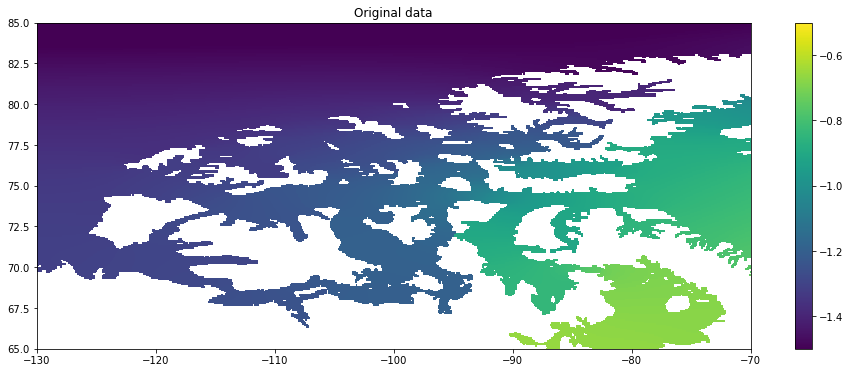

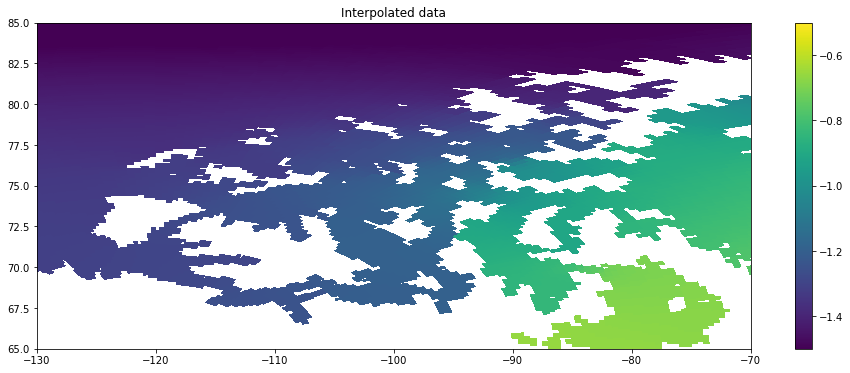

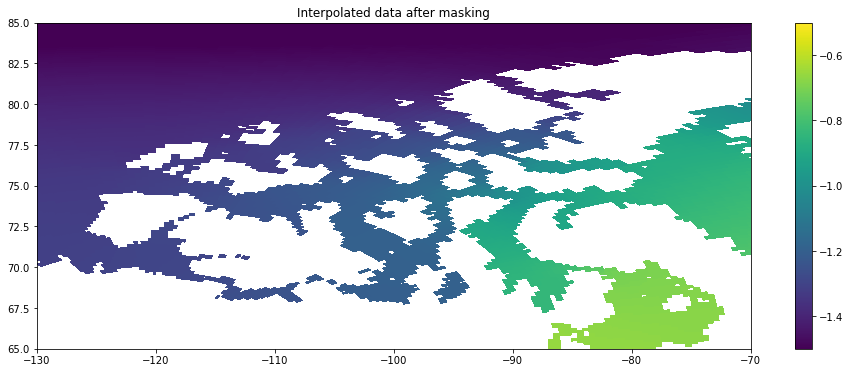

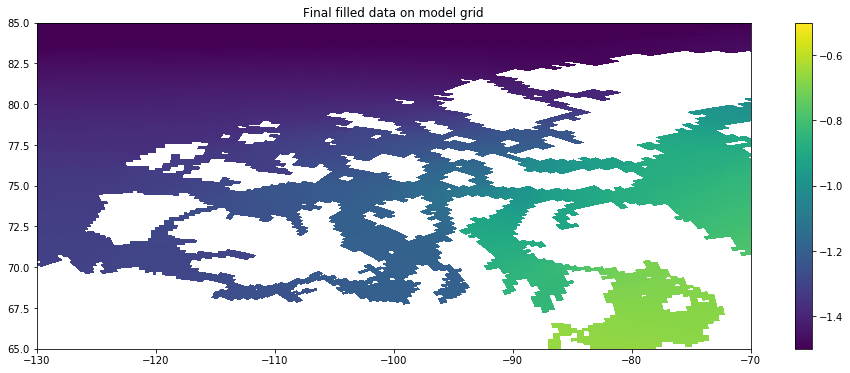

In [39]:
plt.figure(figsize=(16,6))
plt.pcolormesh(src_qlon, src_qlat, numpy.ma.log10( src_data[0] ) ); plt.colorbar();
plt.xlim(-130,-70); plt.ylim(65,85); plt.clim(-1.5,-.5); plt.title('Original data');
plt.figure(figsize=(16,6))
plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10( q_int ) ); plt.colorbar();
plt.xlim(-130,-70); plt.ylim(65,85); plt.clim(-1.5,-.5); plt.title('Interpolated data');
plt.figure(figsize=(16,6))
plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10( q ) ); plt.colorbar();
plt.xlim(-130,-70); plt.ylim(65,85); plt.clim(-1.5,-.5); plt.title('Interpolated data after masking');
plt.figure(figsize=(16,6))
plt.pcolormesh(ocn_qlon, ocn_qlat, numpy.ma.log10( test ) ); plt.colorbar();
plt.xlim(-130,-70); plt.ylim(65,85); plt.clim(-1.5,-.5); plt.title('Final filled data on model grid');